#MFCC:
in this python notebook we show the necessary operations for mfcc extraction.
For this notebook to run well please upload a wav file under the name "seven.wav" in the colaboratory virtual machine

In [1]:
!pip install librosa
!pip install soundfile
import librosa
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
ipd.Audio('seven.wav') # load a local WAV file

ValueError: ignored

In [2]:
def plot_sig(file_path="seven.wav"):
  s,sr=sf.read(file_path)
  time=np.linspace(0,len(s)/sr,len(s))
  plt.plot(time,s)
  plt.show()

plot_sig()

RuntimeError: ignored

In [0]:
def pre_emph(sig,coef=0.97):
  """we bring down the mean of the signal to 0"""
  sig=sig-np.mean(sig)
  """ """
  emph_sig = np.append(sig[0], sig[1:] - coef * sig[:-1])
  return(emph_sig)


In [0]:
def framesig(s,sr=16000,frame_len=0.025,overlap=0.01):
  """frame size / overlap in s"""
  
  size=int(np.floor(frame_len*sr))
  step=int(np.floor(overlap*sr))
  frames=[]
  num_frames=int(np.floor((len(s)-size)/step))
  for i in range (num_frames):
              frames.append(s[i*step:i*step+size])
  #we apply hamming window
  frames *= np.hamming(size)
  frames=np.asarray(frames)
  return(frames)

s,sr=sf.read("seven.wav")
s=pre_emph(s)
frames=framesig(s,sr)
print(len(frames))
    

In [0]:
def plot_powerspec(s,sr,nfft=512):
  ft=np.fft.fft(s,nfft)[:nfft//2]
  yf=np.abs(ft)
  """calculating power periodigram"""
  pf=(yf**2)/(nfft//2) 
  xf=np.fft.fftfreq(nfft,1/sr)[:nfft//2]
  plt.plot(xf,pf)
  plt.show()

plot_powerspec(s,sr)

  
  
            
                       

In [0]:
def powerspec(s,sr,nfft=512):
  ft=np.fft.fft(s,nfft)[:nfft//2]
  yf=np.abs(ft)
  """calculating power periodigram"""
  pf=(yf**2)/(nfft//2) 
  xf=np.fft.fftfreq(nfft,1/sr)[:nfft//2]
  return(pf)
#Please recheck the hz2mel and mel2hz coefficients
def hz2mel(hz):
    return 2595 * np.log10(1 + hz/700.0)
def mel2hz(mel):
    return 700*(10**(mel/2595.0)-1)



In [0]:
def filterbanks(num_filters=26,min_freq=300,max_freq=8000,sr=16000,nfft=512):
  """returns num_filters mel filterbanks each filterbank of size nfft//2"""
  min_mel=hz2mel(min_freq)
  max_mel=hz2mel(max_freq)
  mel_points=np.linspace(min_mel,max_mel,num_filters+2) #numfilters+2 because we add the points at the edges.
  hz_points=mel2hz(mel_points)
  pt_idx=np.floor((nfft+1)*hz_points/sr)
  pt_idx=[int(i) for i in pt_idx]#the index of the point corresponding to each frequency in hz_points in the list xf
  filters=[]
  for i in range(num_filters):
    filter=[]
    filter=[0]*(pt_idx[i]-1)
    a= 1/(pt_idx[i+1]-pt_idx[i])
    b= -pt_idx[i]/(pt_idx[i+1]-pt_idx[i])
    for k in range (pt_idx[i],pt_idx[i+1]+1):
        filter.append(a*k+b)
    #slope doesnt change
    b2= a*pt_idx[i+2]
    for k in range (pt_idx[i+1]+1,pt_idx[i+2]+1):
        filter.append(-a*k+b2)
    filter+=[0]*(nfft//2-pt_idx[i+2])
    assert(len(filter)==nfft//2)
    filters.append(filter)
  filters=np.asarray(filters)
  return(filters)

filters=filterbanks(26)
plt.plot(filters[1],'b',filters[2],'r',filters[3],'y^',filters[9],'b',filters[11],'g^',filters[20],"y")
plt.show()

  

In [0]:
def lg_fbk_eng(ps,num_filters=26,min_freq=300,max_freq=8000,sr=16000,nfft=512):
  
  #Ys must be a frame powerspectrum
  filters=filterbanks(num_filters,min_freq,max_freq,sr,nfft)
  #We multiply the powerspectrum with a filter each time
  energies=[np.dot(ps,filter.T) for filter in filters]
  log_energies=np.log(energies)
  
  return(log_energies)

"""frames_ps :list of the powerspectrum of each frame"""
frames_ps=[]
for frame in frames:
  frames_ps.append(powerspec(frame,sr))

lg_cofs = [lg_fbk_eng(ps) for ps in frames_ps]

lg_cofs=np.asarray(lg_cofs)

print(lg_cofs.shape)
print(lg_cofs[1])


  
  


In [0]:
from scipy.fftpack import dct 

def mfccv(lg_eng_cofs,num_cep=13):
  """by definition in mfcc we take the num_cep coefficients from the log_fbk_energy of the frame"""
  mfcc_coefs=dct(lg_eng_cofs,type=2,norm='ortho')[:num_cep]
  return(mfcc_coefs)

mfcc=[mfccv(cofs) for cofs in lg_cofs ]
mfcc=np.asarray(mfcc)
print(mfcc.shape )
print(mfcc[1])

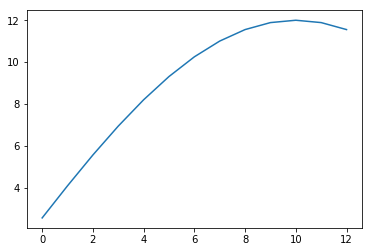

In [3]:
def lift(lifter_num=22,mfcc_num=13):
  """liftering is an optional operation
   lifter used in amplifies some of the higher cepstral coefficients, which would normally have a lower amplitude"""
  
  lifter_num=22

  lifter=1+(lifter_num/2)*np.sin(np.pi*(1+np.arange(mfcc_num))/lifter_num)
  

  plt.plot(lifter)
 
  
lift()


  
  

In [0]:
def mfcc(file,emph=0.97,frame_len=0.025,overlap=0.01,nfft=512,num_filters=26,min_freq=300,max_freq=8000,num_cep=13,lifter=True,lifter_num=22):
  s,sr=sf.read(file)
  s=pre_emph(s,emph)
  frames=framesig(s,sr)
  mfccs=[]
  for frame in frames:
    ps=powerspec(frame,sr,nfft)
    lg_eng=lg_fbk_eng(ps,num_filters,min_freq,max_freq,sr,nfft)
    mfcc=mfccv(lg_eng,num_cep)
    mfccs.append(mfcc)
    
  if lifter:
    lifter=1+(lifter_num/2)*np.sin(np.pi*(1+np.arange(num_cep))/lifter_num)
    mfccs*=lifter
  mfccs=np.asarray(mfccs)
  
  return(mfccs)

rec_mfcc=mfcc("seven.wav")
print(rec_mfcc.shape)
print(rec_mfcc[1])

"""We benchmark against the librosa mfccs
We conclude that the values are in the same range but a bit different, it can be due to many operations like liftering or hamming or the type of the cosine transform"""
mfcc2=librosa.feature.mfcc(s,sr, S=None, n_mfcc=13, dct_type=2, norm='ortho')
#print(mfcc2[1])
    
    